# Data Preprocessing and Modeling

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, Adadelta, Adagrad, SGD, RMSprop

import os

In [2]:
from tensorflow.random import set_seed
set_seed(321)

import numpy as np
np.random.seed(123)

***
## Preprocessing

### Create directory paths for image data

In [3]:
data_train_dir = '../chest_xray/train/'
data_test_dir = '../chest_xray/test/'
data_val_dir = '../chest_xray/val/'

In [4]:
train_dir_pneumonia = '../chest_xray/train/PNEUMONIA'
train_dir_normal = '../chest_xray/train/NORMAL'
test_dir_pneumonia = '../chest_xray/test/PNEUMONIA'
test_dir_normal = '../chest_xray/test/NORMAL'
val_dir_pneumonia = '../chest_xray/val/PNEUMONIA'
val_dir_normal = '../chest_xray/val/NORMAL'

In [5]:
# Review image count
print('Train Pneumonia: ', len(os.listdir(train_dir_pneumonia)))
print('Train Normal: ', len(os.listdir(train_dir_normal)))
print('Test Pneumonia: ', len(os.listdir(test_dir_pneumonia)))
print('Test Normal: ', len(os.listdir(test_dir_normal)))
print('Val Pneumonia: ', len(os.listdir(val_dir_pneumonia)))
print('Val Normal: ', len(os.listdir(val_dir_normal)))

Train Pneumonia:  3875
Train Normal:  1341
Test Pneumonia:  390
Test Normal:  234
Val Pneumonia:  8
Val Normal:  8


### Create data generators
Creating data generators of training, testing, validation data. I want the pixels for each image to be 128 X 128 so I put that in target_size. The class_mode is binary since this is a binary problem. I set the batch_size according to the image count above.

In [ ]:
img_size = (128,128)

In [6]:
train_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_train_dir,
                                                                            target_size=,
                                                                            batch_size=5216,
                                                                            class_mode='binary',
                                                                            seed=123)

Found 5216 images belonging to 2 classes.


In [7]:
test_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_test_dir,
                                                                            target_size=(224,224),
                                                                            batch_size=624,
                                                                            class_mode='binary',
                                                                            seed=123)

Found 624 images belonging to 2 classes.


In [8]:
val_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_val_dir,
                                                                            target_size=(224,224),
                                                                            batch_size=624,
                                                                            class_mode='binary',
                                                                            seed=123)

Found 16 images belonging to 2 classes.


### Review Class Indices

In [9]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Create datasets

In [12]:
train_images, train_labels = next(train_generator)

In [13]:
test_images, test_labels = next(test_generator)

In [14]:
val_images, val_labels = next(val_generator)

### Review image shapes 

In [15]:
print('Train Images Shape:', np.shape(train_images))
print('Train Labels Shape:', np.shape(train_labels))
print('Test Images Shape:' , np.shape(test_images))
print('Test Labels Shape:' , np.shape(test_labels))
print('Validation Images Shape:', np.shape(val_images))
print('Validation Labels Shape:', np.shape(val_labels))

Train Images Shape: (5216, 224, 224, 3)
Train Labels Shape: (5216,)
Test Images Shape: (624, 224, 224, 3)
Test Labels Shape: (624,)
Validation Images Shape: (16, 224, 224, 3)
Validation Labels Shape: (16,)


***
## Modeling

### Baseline model: 3 Convolution layes, 3 max pooling layers, and 1 fully connected layer

In [16]:
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

baseline_model = models.Sequential()

baseline_model.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))

baseline_model.add(MaxPooling2D((2, 2)))

baseline_model.add(Conv2D(32, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(2, 2))

baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D((2, 2)))

baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

In [17]:
baseline_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [18]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [19]:
base_history = baseline_model.fit(train_images,
                       train_labels,
                       epochs=25,
                       batch_size=50,
                       validation_data=(val_images, val_labels))

Epoch 1/25
105/105 [==============================] - 260s 2s/step - loss: 0.3422 - acc: 0.8487 - val_loss: 0.3241 - val_acc: 0.8125
Epoch 2/25
105/105 [==============================] - 246s 2s/step - loss: 0.1092 - acc: 0.9569 - val_loss: 1.2619 - val_acc: 0.6250
Epoch 3/25
105/105 [==============================] - 257s 2s/step - loss: 0.0955 - acc: 0.9655 - val_loss: 0.1983 - val_acc: 0.8750
Epoch 4/25
105/105 [==============================] - 261s 2s/step - loss: 0.0663 - acc: 0.9762 - val_loss: 0.1415 - val_acc: 1.0000
Epoch 5/25
105/105 [==============================] - 245s 2s/step - loss: 0.0616 - acc: 0.9760 - val_loss: 0.5058 - val_acc: 0.6875
Epoch 6/25
105/105 [==============================] - 250s 2s/step - loss: 0.0463 - acc: 0.9826 - val_loss: 0.3123 - val_acc: 0.8125
Epoch 7/25
105/105 [==============================] - 246s 2s/step - loss: 0.0370 - acc: 0.9873 - val_loss: 0.2049 - val_acc: 0.9375
Epoch 8/25
105/105 [==============================] - 258s 2s/step - 

In [29]:
import seaborn as sns
def eval_results(results):

    history = results.history
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.legend(['acc', 'val_acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    y_hat_test = results.model.predict(test_images)
    thresh = 0.5
    y_pred = (y_hat_test < thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Model Confusion Matrix')
    plt.show()
    print('\n')

    print(classification_report(y_true, y_pred))
    print('\n')

    test_loss, test_acc = results.model.evaluate(test_images, test_labels)
    print(f'Test Loss: {test_loss}')
    print(f'Test Acc: {test_acc}')
    

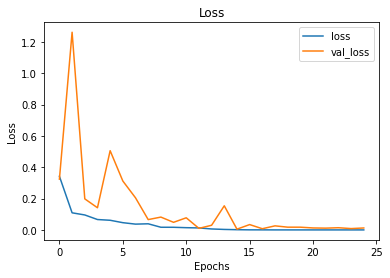

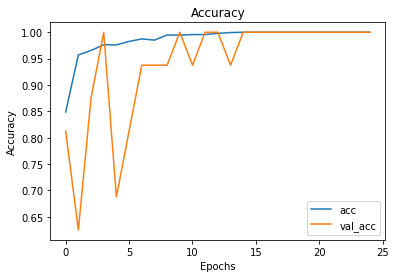

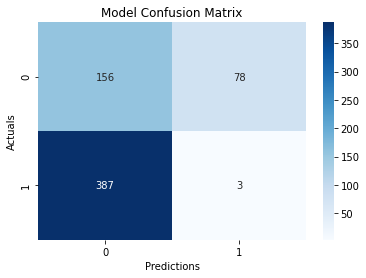



              precision    recall  f1-score   support

           0       0.29      0.67      0.40       234
           1       0.04      0.01      0.01       390

    accuracy                           0.25       624
   macro avg       0.16      0.34      0.21       624
weighted avg       0.13      0.25      0.16       624



20/20 [==============================] - 8s 391ms/step - loss: 4.0510 - acc: 0.7452
Test Loss: 4.051008701324463
Test Acc: 0.745192289352417


In [30]:
eval_results(base_history)

### Model 2: Looking at class imbalance, use early stopping, increase epochs

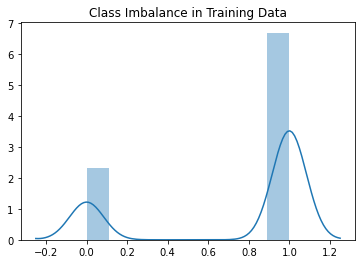

In [46]:
# Review training data class imbalance
sns.distplot(train_labels)
plt.title('Class Imbalance in Training Data')
plt.show()

In [47]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
weights_dict = dict(zip(np.unique(train_labels), weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [48]:
# Use early stopping and reduce learning rate 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [early_stopping, lr]

In [49]:
model_2 = models.Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [50]:
model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [51]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 107, 107, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 179776)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [52]:
results2 = model_2.fit(train_images,
                   train_labels,
                   epochs=50,
                   batch_size=35,
                   validation_data=(val_images, val_labels),
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/50
150/150 [==============================] - 364s 2s/step - loss: 0.2747 - acc: 0.9005 - val_loss: 0.1835 - val_acc: 0.9375
Epoch 2/50
150/150 [==============================] - 835s 6s/step - loss: 0.0946 - acc: 0.9651 - val_loss: 1.1203 - val_acc: 0.6875
Epoch 3/50
150/150 [==============================] - 350s 2s/step - loss: 0.1028 - acc: 0.9659 - val_loss: 0.3497 - val_acc: 0.8125
Epoch 4/50
150/150 [==============================] - 484s 3s/step - loss: 0.1161 - acc: 0.9563 - val_loss: 0.2017 - val_acc: 0.9375
Epoch 5/50
150/150 [==============================] - 339s 2s/step - loss: 0.0494 - acc: 0.9820 - val_loss: 0.8453 - val_acc: 0.6875
Epoch 6/50
150/150 [==============================] - 336s 2s/step - loss: 0.0552 - acc: 0.9787 - val_loss: 2.1044 - val_acc: 0.5625


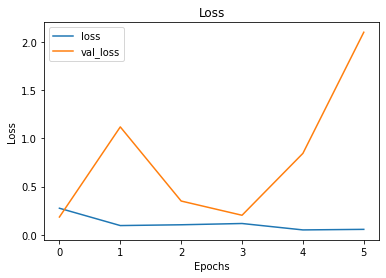

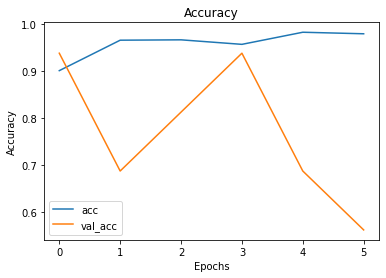

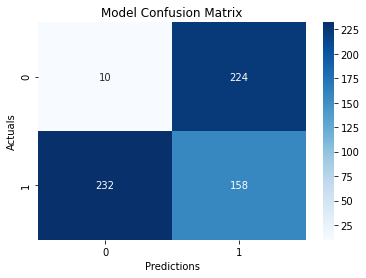



              precision    recall  f1-score   support

           0       0.04      0.04      0.04       234
           1       0.41      0.41      0.41       390

    accuracy                           0.27       624
   macro avg       0.23      0.22      0.23       624
weighted avg       0.27      0.27      0.27       624



20/20 [==============================] - 10s 499ms/step - loss: 1.5767 - acc: 0.7308
Test Loss: 1.5767138004302979
Test Acc: 0.7307692170143127


In [53]:
eval_results(results2)

### Model 3: more layers

In [54]:
model_3 = models.Sequential()

model_3.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(2, 2))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

In [55]:
model_3.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
results_3 = model_3.fit(train_images,
                   train_labels,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stopping])

Epoch 1/50
131/131 [==============================] - 813s 6s/step - loss: 0.7009 - acc: 0.3320 - val_loss: 0.6978 - val_acc: 0.2241
Epoch 2/50
131/131 [==============================] - 803s 6s/step - loss: 0.7088 - acc: 0.3097 - val_loss: 0.7045 - val_acc: 0.2241
Epoch 3/50
131/131 [==============================] - 705s 5s/step - loss: 0.5202 - acc: 0.7658 - val_loss: 0.3116 - val_acc: 0.8534
Epoch 4/50
131/131 [==============================] - 1307s 10s/step - loss: 0.2849 - acc: 0.8814 - val_loss: 0.2244 - val_acc: 0.9215
Epoch 5/50
131/131 [==============================] - 691s 5s/step - loss: 0.2272 - acc: 0.9104 - val_loss: 0.1640 - val_acc: 0.9358
Epoch 6/50
131/131 [==============================] - 14427s 110s/step - loss: 0.1867 - acc: 0.9286 - val_loss: 0.3174 - val_acc: 0.8803
Epoch 7/50
131/131 [==============================] - 745s 6s/step - loss: 0.1649 - acc: 0.9403 - val_loss: 0.1008 - val_acc: 0.9665
Epoch 8/50
 63/131 [=============>................] - ETA: 5:23

In [ ]:
eval_results(results_3)